# candlesticks_pattern_recongnition_(engulfings)_2022

In [11]:
# import logging
import sys

# stdout=sys.stdout
sys.path.append('../../')
# import os
# import random
# import time

# import matplotlib
# import matplotlib.pyplot as plt
# import mplfinance as mpf
# sys.stdout=stdout
import numpy as np
# import numpy as np
import pandas as pd
# from JohnsonUtil import commonTips as cct
# from JSONData import sina_data
from JSONData import tdx_data_Day as tdd

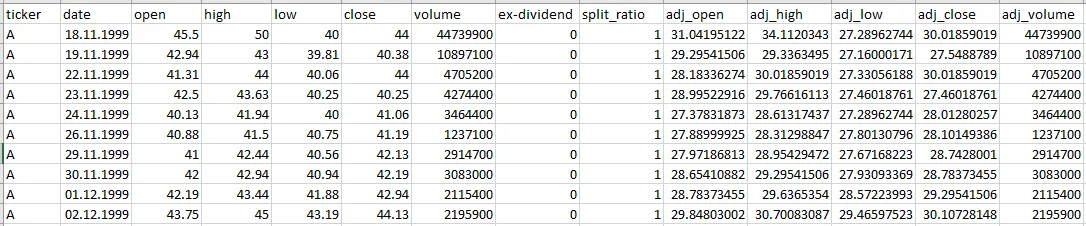

In [12]:
code = '600593'
# Example usage
# price_data = [100, 95, 97, 99, 102, 105, 108, 111,1]
dfc = tdd.get_tdx_Exp_day_to_df(
    code, dl=600, resample='w').sort_index(
    ascending=True).reset_index()
dfc.rename(columns={'vol': 'volume'}, inplace=True)
dfc.rename(columns={'code': 'ticker'}, inplace=True)
df = dfc.loc[:,['ticker', 'date', 'open', 'high', 'low', 'close', 'volume']]
df[:3]

,ticker,date,open,high,low,close,volume
0,600593,2021-07-09,16.88,19.24,16.82,18.30,11243560.0
1,600593,2021-07-13,18.30,19.30,18.01,18.38,13357880.0
2,600593,2021-07-23,17.46,17.46,16.59,16.59,1194600.0


In [13]:
import pandas as pd
import numpy as np

span1 = 20 # number of days (span) for ATR calculation
span2 = 60 # number of days (span) for New High/Low check
span3 = 20 # number of days (span) for New High/Low check
ENG_to_ATR_Ratio_MIN = 1 # lower limit for engulfing candle to ATR ratio
ENG_to_ATR_Ratio_MAX = 2 # higher limit for engulfing candle to ATR ratio
Profit_Loss_Ratio = 3 # X profit(s) vs 1 loss ratio

df = dfc.loc[:,['ticker', 'date', 'open', 'high', 'low', 'close', 'volume']]
# df = pd.read_csv("WIKI_PRICES.csv").iloc[:,[0,1,9,10,11,12,13]]
# df.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume']
df['range'] = df['high'] - df['low']
df['atr'] = df['range'].rolling(window=span1).mean()
df['maxvol'] = df['volume'].rolling(window=span3).max()
df['high/low'] = np.where(df['low']<=df['low'].rolling(span2).min(), 'new low',
                 np.where(df['high']>=df['high'].rolling(span2).max(), 'new high', ''))



In [14]:
df[-5:]

,ticker,date,open,high,low,close,volume,range,atr,maxvol,high/low
122,600593,2023-12-08,20.64,23.40,19.77,21.25,80960374.0,3.63,1.4400,80960374.0,new high
123,600593,2023-12-15,20.83,21.42,19.29,19.55,36423412.0,2.13,1.4670,80960374.0,
124,600593,2023-12-22,19.35,20.36,18.85,19.16,28670441.0,1.51,1.4855,80960374.0,
125,600593,2023-12-29,19.30,20.29,18.40,19.66,19641200.0,1.89,1.4930,80960374.0,
126,600593,2024-01-05,20.23,27.41,19.76,27.41,31468162.0,7.65,1.8335,80960374.0,new high


## conditions

In [15]:
conditions = [(df['ticker'] == df['ticker'].shift(1)) &
              (df['high/low'].shift(1) == "new high") &
              (df['close'] < df['open']) & 
              (df['close'] < df['open'].shift(1)) &
              (df['close'] < df['close'].shift(1)) &
              (df['open'] > df['open'].shift(1)) &
              (df['open'] > df['close'].shift(1)) &
              (df['volume'] == df['maxvol']) &
              (df['range']/df['atr'] > ENG_to_ATR_Ratio_MIN) &
              (df['range']/df['atr'] < ENG_to_ATR_Ratio_MAX)
              ,
              (df['ticker'] == df['ticker'].shift(1)) &
              (df['high/low'].shift(1) == "new low") &
              (df['close'] > df['open']) &
              (df['close'] > df['open'].shift(1)) &
              (df['close'] > df['close'].shift(1)) &
              (df['open'] < df['open'].shift(1)) &
              (df['open'] < df['close'].shift(1)) &
              (df['volume'] == df['maxvol']) &
              (df['range']/df['atr'] > ENG_to_ATR_Ratio_MIN) &
              (df['range']/df['atr'] < ENG_to_ATR_Ratio_MAX)
             ]

choices = ["bear", "bull"]

df["engulf_event"] = np.select(conditions, choices, default = '')

df['trade_id']=df.engulf_event.replace('',np.nan).notna().cumsum()

df["trade_type"] = 0
df["trade_type"] = np.where(df['engulf_event'] == 'bull','buy',
                        np.where(df['engulf_event'] == 'bear','sell', pd.NA))
df["trade_type"] = df["trade_type"].fillna(method="ffill")

df["trade_price"] = 0
df["trade_price"] = np.where(df['engulf_event'] != '', df['close'], 0)
df["trade_price"] = df["trade_price"].replace(to_replace=0, method='ffill')

df["stop-loss"] = 0
df["stop-loss"] = np.where(df['engulf_event'] != '', df['open'], 0)
df["stop-loss"] = df["stop-loss"].replace(to_replace=0, method='ffill')

df["take-profit"] = 0
df["take-profit"] = np.where(df['engulf_event'] != '', 
                    np.where(df['trade_type'] != 'buy', df['close']+(df['close']-df['open'])*Profit_Loss_Ratio, 
                    np.where(df['trade_type'] != 'sell', df['close']-(df['open']-df['close'])*Profit_Loss_Ratio, 0)), 0)
df["take-profit"] = df["take-profit"].replace(to_replace=0, method='ffill')



In [16]:
conditions2 = [(df['trade_type'] == 'buy')  & (df["high"] >= df["take-profit"])
               ,
               (df['trade_type'] == 'sell') & (df["low"]  <= df["take-profit"])
               ,
               (df['trade_type'] == 'buy')  & (df["low"]  <= df["stop-loss"])
               ,
               (df['trade_type'] == 'sell') & (df["high"] >= df["stop-loss"])
             ]

choices2 = ["profit", "profit", "loss", "loss"]


df["pre-result"] = np.where(df['trade_id']>df['trade_id'].shift(1),'',np.select(conditions2, choices2, default = ''))


df["pre-result2"] = df.groupby(["trade_id"])["pre-result"].apply(lambda x: x.ne('').cumsum())


df["result"] = np.where((df["pre-result2"] == 1) & (df["pre-result"] != ''),df["pre-result"],'')

df["outcome"] = np.where((df["result"] == 'profit') & (df["trade_type"] == 'buy'),df["take-profit"]-df["trade_price"],
                np.where((df["result"] == 'profit') & (df["trade_type"] == 'sell'),df["trade_price"]-df["take-profit"],
                np.where((df["result"] == 'loss') & (df["trade_type"] == 'buy'),df["stop-loss"]-df["trade_price"],
                np.where((df["result"] == 'loss') & (df["trade_type"] == 'sell'),df["trade_price"]-df["stop-loss"],0))))




## conditions2

In [29]:
df.loc[:,['high/low',]]
cols =  [ x for x in range(7,len(df.columns))]
ohcl = [ x for x in range(0,3)]
ohcl.extend(cols)
df.iloc[:,ohcl]
# df.columns

,ticker,date,open,range,atr,maxvol,high/low,engulf_event,trade_id,trade_type,trade_price,stop-loss,take-profit,pre-result,pre-result2,result,outcome
0,600593,2021-07-09,16.88,2.42,NaN,NaN,,,0,<NA>,0.0,0.0,0.0,,0,,0.0
1,600593,2021-07-13,18.30,1.29,NaN,NaN,,,0,<NA>,0.0,0.0,0.0,,0,,0.0
2,600593,2021-07-23,17.46,0.87,NaN,NaN,,,0,<NA>,0.0,0.0,0.0,,0,,0.0
3,600593,2021-07-30,15.76,2.93,NaN,NaN,,,0,<NA>,0.0,0.0,0.0,,0,,0.0
4,600593,2021-08-06,12.19,1.26,NaN,NaN,,,0,<NA>,0.0,0.0,0.0,,0,,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,600593,2023-12-08,20.64,3.63,1.4400,80960374.0,new high,,0,<NA>,0.0,0.0,0.0,,0,,0.0
123,600593,2023-12-15,20.83,2.13,1.4670,80960374.0,,,0,<NA>,0.0,0.0,0.0,,0,,0.0
124,600593,2023-12-22,19.35,1.51,1.4855,80960374.0,,,0,<NA>,0.0,0.0,0.0,,0,,0.0
125,600593,2023-12-29,19.30,1.89,1.4930,80960374.0,,,0,<NA>,0.0,0.0,0.0,,0,,0.0


In [18]:
df[df['high/low'].str.contains('new low') | df['high/low'].str.contains('new high')].iloc[:,cols]

,range,atr,maxvol,high/low,engulf_event,trade_id,trade_type,trade_price,stop-loss,take-profit,pre-result,pre-result2,result,outcome
121,4.02,1.3090,30615492.0,new high,,0,<NA>,0.0,0.0,0.0,,0,,0.0
122,3.63,1.4400,80960374.0,new high,,0,<NA>,0.0,0.0,0.0,,0,,0.0
126,7.65,1.8335,80960374.0,new high,,0,<NA>,0.0,0.0,0.0,,0,,0.0


## to_excel

In [19]:
df_result = df[df.result != '']
# df.to_excel("output.xlsx")
df_result

,ticker,date,open,high,low,close,volume,range,atr,maxvol,...,engulf_event,trade_id,trade_type,trade_price,stop-loss,take-profit,pre-result,pre-result2,result,outcome


# CandleStick

In [20]:
class CandleStick:

    def is_bearish_candle(self,candle):
        return candle["Close"] <  candle["Open"]

    def is_bullish_candle(self,candle):
        return candle["Close"] > candle["Open"]

    def is_bullish_engulfing(self,candles,pos=-1):
        if candles.shape[0] < 2:
                raise BadDataError("Minimun two candles require")
        curr_candle = candles.iloc[pos]
        prev_candle = candles.iloc[pos-1]

        #check for pattern
        if  (self.is_bearish_candle(prev_candle)\
            and curr_candle["Close"] > prev_candle["Open"] \
            and curr_candle["Open"] <prev_candle["Close"]):
            return True
        return False
    
    def is_hammer_candle(self,candle,pos=-1,lower_wick = 0.6, body = 0.2, upper_wick = 0.2):
        curr_candle = candle.iloc[pos]
        if candles.shape[0] < 1:
                raise BadDataError("Minimun one candles require")
        candle_length = curr_candle["High"] - curr_candle["Low"]
        if self.is_bullish_candle(curr_candle):
            candle_upper_wick = curr_candle["High"]-curr_candle["Close"]
            candle_lower_wick = curr_candle["Open"]-curr_candle["Low"]
            candle_body = curr_candle["Close"] - curr_candle["Open"]
            if candle_body <= body * candle_length and candle_upper_wick <= upper_wick * candle_length:
                return True
        elif self.is_bearish_candle(curr_candle):
            candle_upper_wick = curr_candle["High"]-curr_candle["Open"]
            candle_lower_wick = curr_candle["Close"]-curr_candle["Low"]
            candle_body = curr_candle["Open"] - curr_candle["Close"]
            if candle_body <= body * candle_length and candle_upper_wick <= upper_wick * candle_length:
                return True
        return False
    
    def is_inverse_hammer_candle(self,candle,pos=-1,lower_wick = 0.2, body = 0.2, upper_wick = 0.6):
        curr_candle = candle.iloc[pos]
        candle_length = curr_candle["High"] - curr_candle["Low"]
        if self.is_bullish_candle(curr_candle):
            candle_body = curr_candle["Close"] - curr_candle["Open"]
            candle_upper_wick = curr_candle["High"]-curr_candle["Close"]
            candle_lower_wick = curr_candle["Open"]-curr_candle["Low"]
            if candle_body <= body * candle_length and candle_lower_wick <= lower_wick * candle_length:
                return True
        elif self.is_bearish_candle(curr_candle):
            candle_body = curr_candle["Open"] - curr_candle["Close"]
            candle_upper_wick = curr_candle["Open"]-curr_candle["High"]
            candle_lower_wick = curr_candle["Close"]-curr_candle["Low"]
            if candle_body <= body * candle_length and candle_lower_wick <= lower_wick * candle_length:
                return True
        return False
    
    def is_doji_candle(self,candle,pos=-1,lower_wick = 0.4, body = 0.02, upper_wick = 0.4):
        curr_candle = candle.iloc[pos]
        candle_length = curr_candle["High"] - curr_candle["Low"]
        if self.is_bullish_candle(curr_candle):
            candle_body = curr_candle["Close"] - curr_candle["Open"]
            candle_upper_wick = curr_candle["High"]-curr_candle["Close"]
            candle_lower_wick = curr_candle["Open"]-curr_candle["Low"]
            if candle_body <= body * candle_length and candle_upper_wick >= upper_wick*candle_length and candle_lower_wick >= lower_wick*candle_length:
                return True
        elif self.is_bearish_candle(curr_candle):
            candle_body = curr_candle["Open"] - curr_candle["Close"]
            candle_upper_wick = curr_candle["High"]-curr_candle["Open"]
            candle_lower_wick = curr_candle["Close"]-curr_candle["Low"]
            if candle_body <= body * candle_length and candle_upper_wick >= upper_wick*candle_length and candle_lower_wick >= lower_wick*candle_length:
                return True
        return False